In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
from collections import Counter
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from tqdm.auto import tqdm

In [2]:
from numba import set_num_threads

set_num_threads(16)

In [3]:
import anndata as ad

# Load raw data

In [4]:
adata_merged = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/raw_uniformed.h5ad")

In [5]:
adata_merged

AnnData object with n_obs × n_vars = 274346 × 42117
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue'

In [6]:
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)

# Process without integration

In [7]:
#sc.pp.highly_variable_genes(adata_merged,batch_key="str_batch", n_top_genes=2000)
#adata_merged = adata_merged[:,adata_merged.var.highly_variable]
adata_merged = adata_merged[:,pd.read_csv("../gene_list.csv",index_col=0)['gene_name']]

In [8]:
adata_merged

View of AnnData object with n_obs × n_vars = 274346 × 2000
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue'
    uns: 'log1p'

In [10]:
adata_merged.write_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/Results/raw.h5ad")

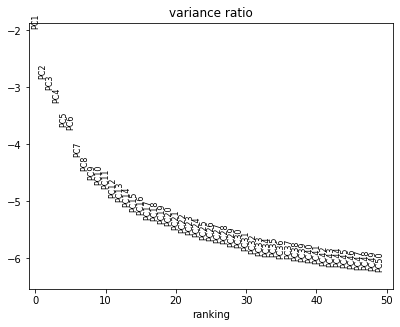

In [6]:
# PCA
sc.tl.pca(adata_merged, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_merged, n_pcs=50, log=True)

In [7]:
sc.pp.neighbors(adata_merged, n_pcs=30)
sc.tl.umap(adata_merged)

2023-11-01 20:32:31.162889: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(adata_merged, color=['celltype', 'study'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_COVID/Raw.results.png", bbox_inches='tight')

In [11]:
adata_merged.write_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/Results/merged_result.h5ad")

# BBKNN

In [4]:
adata_BBKNN = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/Results/raw.h5ad")

In [6]:
import time

In [7]:
start_time = time.time()
# PCA
sc.tl.pca(adata_BBKNN, svd_solver='arpack')

import bbknn
bbknn.bbknn(adata_BBKNN, batch_key='study')

sc.tl.umap(adata_BBKNN)
end_time = time.time()

/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/

In [8]:
print(end_time-start_time)

346.32843589782715


In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(adata_BBKNN, color=['celltype', 'study'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_COVID/BBKNN.results.png", bbox_inches='tight')

In [21]:
adata_BBKNN.write_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/Results/BBKNN_result.h5ad")

# harmony

In [9]:
import scanpy.external as sce

In [10]:
adata_harmony = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/raw.h5ad")

In [11]:
start_time = time.time()

# PCA
sc.tl.pca(adata_harmony, svd_solver='arpack')
# harmony
sce.pp.harmony_integrate(adata_harmony, 'study')

sc.pp.neighbors(adata_harmony, use_rep='X_pca_harmony')
sc.tl.umap(adata_harmony)

end_time = time.time()

2023-11-07 15:21:32,896 - harmonypy - INFO - Iteration 1 of 10
2023-11-07 15:23:07,691 - harmonypy - INFO - Iteration 2 of 10
2023-11-07 15:24:39,647 - harmonypy - INFO - Iteration 3 of 10
2023-11-07 15:26:07,789 - harmonypy - INFO - Iteration 4 of 10
2023-11-07 15:27:34,584 - harmonypy - INFO - Iteration 5 of 10
2023-11-07 15:29:02,775 - harmonypy - INFO - Converged after 5 iterations


In [12]:
end_time-start_time

737.7404992580414

In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(adata_harmony, color=['celltype', 'study'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_COVID/harmony.results.png", bbox_inches='tight')

In [29]:
adata_harmony.write_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/harmony.h5ad")

# scVI without Annotation

In [30]:
import scvi

Global seed set to 0


In [31]:
adata_scVI = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/raw_uniformed.h5ad")
adata_scVI = adata_scVI[:,pd.read_csv("../gene_list.csv",index_col=0)['gene_name']]

In [40]:
adata_scVI = adata_scVI.copy()

In [41]:
scvi.model.SCVI.setup_anndata(adata_scVI, batch_key="study")

In [42]:
vae = scvi.model.SCVI(adata_scVI, n_layers=2, n_latent=30, gene_likelihood="nb")

In [43]:
vae.train(use_gpu=3)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 29/29: 100%|██████████| 29/29 [12:15<00:00, 25.35s/it, loss=526, v_num=1]


In [44]:
adata_scVI.obsm["X_scVI"] = vae.get_latent_representation()

In [46]:
sc.pp.neighbors(adata_scVI, use_rep="X_scVI")
sc.tl.umap(adata_scVI)

In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(adata_scVI, color=['celltype', 'study'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_COVID/scVI.results.png", bbox_inches='tight')

In [48]:
adata_scVI.write_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/scVI.h5ad")

In [45]:
vae.save("/nfs/public/cell_gpt_data/Intergation_COVID//Results/scVI_model.pt")

# scANVI

In [50]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata_scVI,
    labels_key="celltype",
    unlabeled_category="Unclassified",
)

In [51]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100,use_gpu=3)

INFO     Training for 20 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 20/20: 100%|██████████| 20/20 [18:15<00:00, 54.76s/it, loss=642, v_num=1]


In [52]:
adata_scVI.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata_scVI)
adata_scVI.obsm["X_scANVI_MDE"] = scvi.model.utils.mde(adata_scVI.obsm["X_scANVI"])

In [54]:
adata_scVI.write_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/scANVI.h5ad")

# Seurat integrated

In [55]:
adata_seurat = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/Seurat_result.h5ad")

In [56]:
adata_seurat

AnnData object with n_obs × n_vars = 274346 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author.PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue'
    var: 'gene_name'

In [57]:
sc.pp.pca(adata_seurat)

In [ ]:
sc.pl.pca_variance_ratio(adata_seurat)

In [59]:
sc.pp.neighbors(adata_seurat,n_pcs=10)
sc.tl.umap(adata_seurat)

In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(
    adata_seurat,  color=['celltype', 'study'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_COVID/Seurat.results.png", bbox_inches='tight')

In [68]:
adata_seurat.write_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/Seurat_result.h5ad")

# FastMNN

In [61]:
adata_fastmnn = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/FastMNN_result.h5ad")

In [62]:
adata_fastmnn

AnnData object with n_obs × n_vars = 274346 × 1961
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author.PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue'
    var: 'gene_name'

In [63]:
sc.pp.pca(adata_fastmnn)

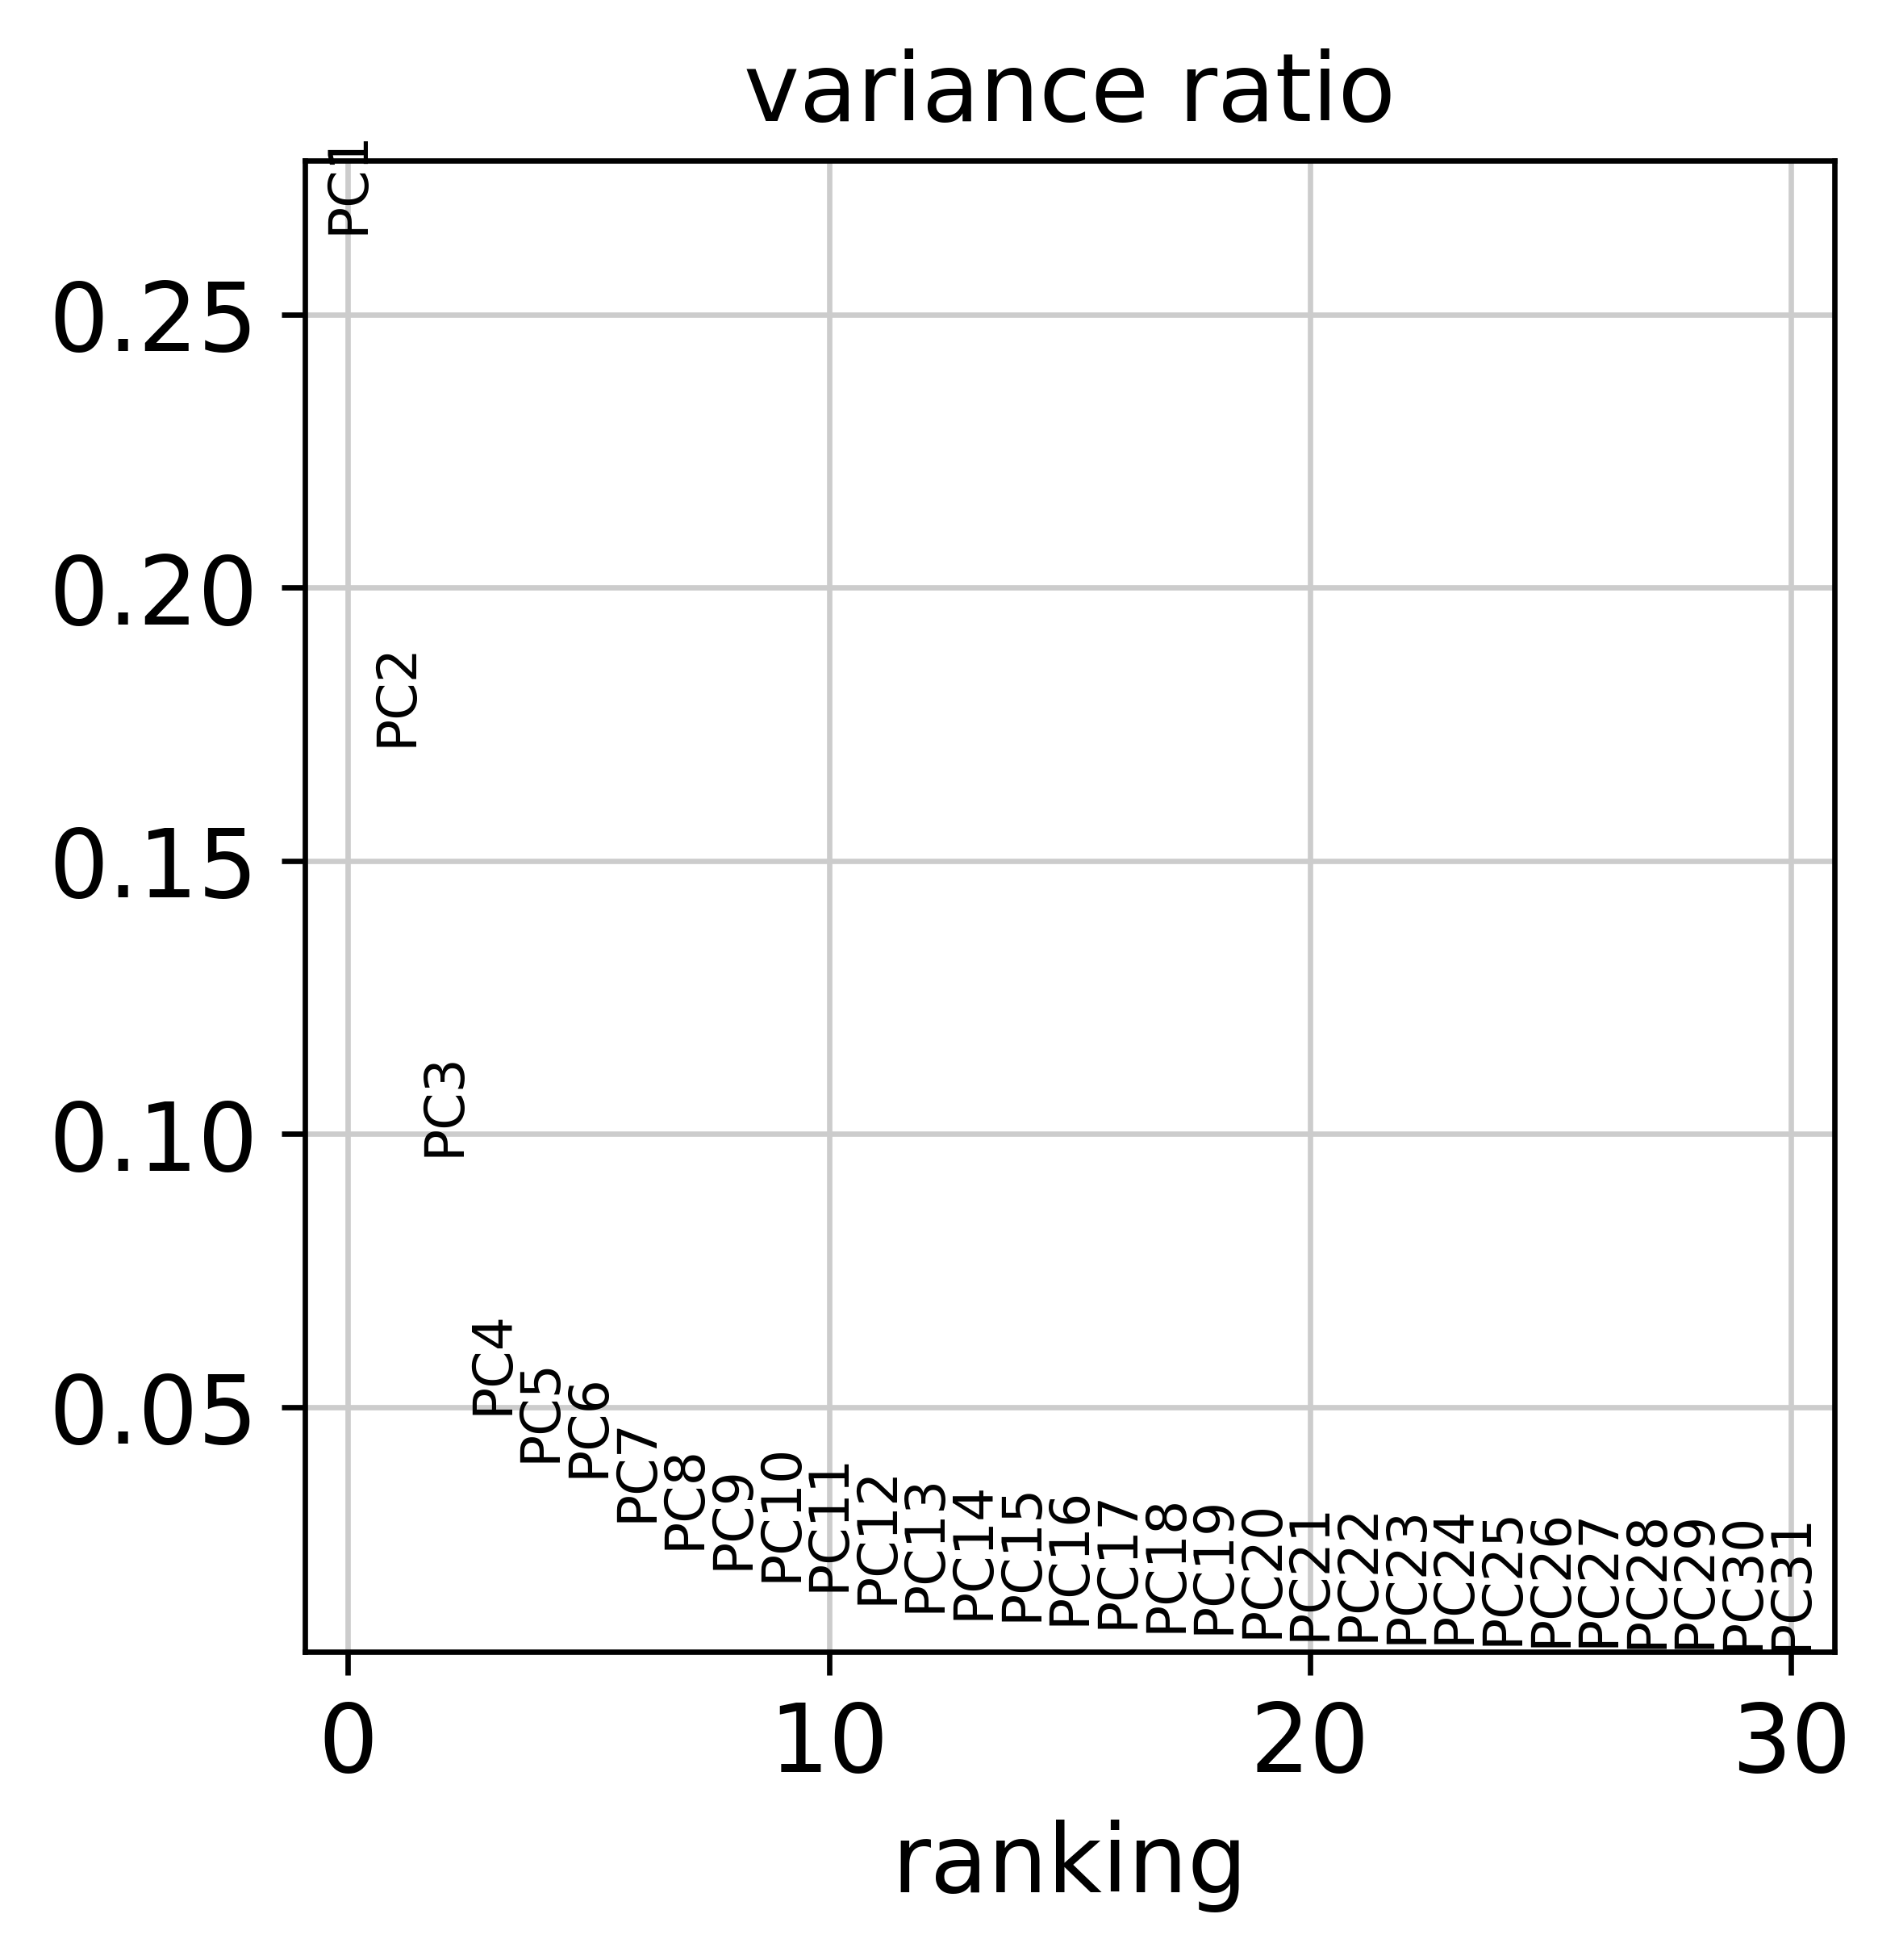

In [64]:
sc.pl.pca_variance_ratio(adata_fastmnn)

In [65]:
sc.pp.neighbors(adata_fastmnn,n_pcs=10)
sc.tl.umap(adata_fastmnn)

In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(
    adata_fastmnn,  color=['celltype', 'study'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_COVID/FastMNN.results.png", bbox_inches='tight')

In [67]:
adata_fastmnn.write_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/FastMNN_result.h5ad")

# Assess

In [69]:
adata_all = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/scANVI.h5ad")

In [70]:
adata_all

AnnData object with n_obs × n_vars = 274346 × 2000
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'X_scANVI', 'X_scANVI_MDE', 'X_scVI', 'X_umap'

In [72]:
adata_merged = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/merged_result.h5ad")
adata_harmony = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/harmony.h5ad")
# adata_scanorama = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/scanorama_result.h5ad")
adata_bbknn = sc.read("/nfs/public/cell_gpt_data/Intergation_COVID//Results/BBKNN_result.h5ad")

In [74]:
adata_all.obsm['scVI'] = adata_all.obsm['X_scVI']
adata_all.obsm['scANVI'] = adata_all.obsm['X_scANVI']
adata_all.obsm['Seurat'] = adata_seurat.obsm['X_pca']
adata_all.obsm['FastMNN'] = adata_fastmnn.obsm['X_pca']
# adata_all.obsm['scanorama'] = adata_scanorama.obsm['X_scanorama']
adata_all.obsm['harmony'] = adata_harmony.obsm['X_pca_harmony']
adata_all.obsm['umap_BBKNN'] = adata_bbknn.obsm['X_umap']
adata_all.obsm['raw'] = adata_merged.obsm['X_pca']

In [75]:
del adata_all.obsm['X_scANVI']
del adata_all.obsm['X_scANVI_MDE']
del adata_all.obsm['X_scVI']
del adata_all.obsm['X_umap']

In [76]:
adata_all

AnnData object with n_obs × n_vars = 274346 × 2000
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'scVI', 'scANVI', 'Seurat', 'FastMNN', 'harmon

In [79]:
adata_all.write_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/Results/all_methods.h5ad")

In [ ]:
adata_all = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/Results/all_methods.h5ad")

In [86]:
adata_scMuLan = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/Results/scMulan_only.h5ad")
adata_scMuLan = adata_scMuLan[adata_all.obs.index,:]

In [ ]:
adata_all.obsm['scMuLan'] = adata_scMuLan.obsm['scMuLan']
adata_all.obsm['scMuLan_awared'] = adata_scMuLan.obsm['scMuLan_awared']

In [89]:
adata_all.write_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID//Results/all_methods.h5ad")

In [6]:
adata_all = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/Results/all_methods.h5ad")

In [7]:
adata_all

AnnData object with n_obs × n_vars = 274346 × 2000
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'FastMNN', 'Seurat', 'harmony', 'raw', 'scANVI

In [7]:
adata_scgpt = sc.read_h5ad()

AnnData object with n_obs × n_vars = 274346 × 2000
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors', 'study_colors', 'umap'
    obsm: 'FastMNN', 'Seurat', 'harmony', 'raw', 'scANVI

In [4]:
adata_all = sc.read_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/Results/all_methods.h5ad")

In [5]:
df = pd.read_csv("/nfs/public/cell_gpt_data/Intergation_COVID/Results/Geneformer6L_COVID.csv",index_col=0)
adata_all.obsm['geneformer'] = np.array(df)

In [6]:
adata_all.write_h5ad("/nfs/public/cell_gpt_data/Intergation_COVID/Results/all_methods.h5ad")

In [7]:
sc.pp.neighbors(adata_all,use_rep="geneformer")
sc.tl.umap(adata_all)

/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data1/chenyx/anaconda3/envs/sc_R4_Py/lib/python3.9/site-packages/

In [ ]:
sc.set_figure_params(dpi=300)
fig = sc.pl.umap(
    adata_all,  color=['celltype', 'study'],return_fig=True,legend_fontsize='xx-small',ncols=1)
fig.set_size_inches(8, 8)
fig.savefig("Integration_results_COVID/geneformer.results.png", bbox_inches='tight')